# COVID-19 Diagnostic Dicease Prediction - 03 - Results after RFECV and GridSearchCV

In [1]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, make_scorer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# model processing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# other tools
from utils import dataframe_utils, preprocess_utils, feature_importance_utils, model_utils, preprocess_utils
from utils.estimator_wrapper import *

from joblib import dump, load


### Importing and pre-visualization

In [2]:
df_covid = pd.read_csv('datasets/dataset_preprocessed.csv')
df_covid

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
0,17,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,0,1,0,0,0,0,0,0,0,0
1,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,0,0,0,0,0,0,0,0,0,0
2,9,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,0,0,0,0,0,0,0,0,1,0
3,11,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,0,1,0,0,0,0,0,0,0,0
4,13,0,1.014726,0.854844,-0.178244,0.796029,0.489872,-0.730707,-0.353319,-0.075131,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18,1,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,...,0,0,0,0,0,0,0,0,0,0
358,19,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,...,0,0,0,0,0,0,0,0,0,0
359,19,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,...,0,0,0,0,0,0,0,0,0,0
360,15,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,...,0,0,0,0,0,0,0,0,0,0


### We will eliminate the least important features according to the Random Forest previous results

In [3]:
features_to_drop = ['Parainfluenza 3','Coronavirus229E','Influenza A','Respiratory Syncytial Virus','Adenovirus','Parainfluenza 4','Metapneumovirus']

Note that most of these features were either eliminated during the RFE in other models or got really low feature importance values

In [4]:
df_covid = df_covid.drop(columns = features_to_drop,axis = 1)

## Training and Testing Models

Last time trying to tune hyper parameters for the following models:

- Random Forest
- Support Vector Machine
- Logistic Regression

Scoring function will be F2, since it is more costly to have false negatives than false positives

### Train and Test preparation

In [5]:
class_label = 'SARS-Cov-2 exam result'
columns_x = df_covid.drop(columns = [class_label]).columns
column_y = [class_label]

X_train, X_test, y_train, y_test = train_test_split(
    df_covid[columns_x], df_covid[column_y],  test_size=0.30, random_state=42)

scaler = MinMaxScaler()
scaler.fit(df_covid[columns_x])
dump(scaler, 'saves/minmax_scaler_no_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(data=scaler.transform(X_test),columns=X_train.columns)

In [6]:
f2_scorer = make_scorer(fbeta_score, beta=2)

### Logistic Regression

In [7]:
logistic_regression_params = {
    'C' : [0.1,1,10,100],
    'penalty' : ['l2', 'elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight':[None,'balanced']
}

best_lr,best_lr_params,best_lr_score = model_utils.model_fit_with_grid_search_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
--- Ellapsed time: 4.724100589752197 seconds ---
Best params:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Best score (make_scorer(fbeta_score, beta=2)) 0.7311105357310987
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.6s finished



Performance Report: 
Accuracy: 0.853
Recall: 0.868
Precision: 0.754
F1: 0.786
F2: 0.827



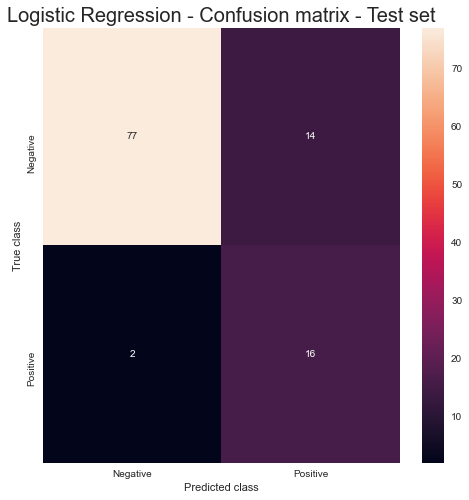

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.904


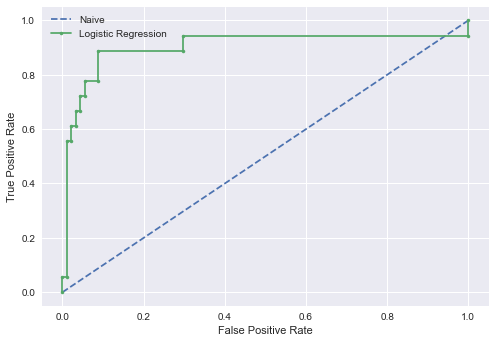

In [8]:
model_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_test_norm,y_test)
# dump(best_lr, 'saves/logistic_regression_no_imputation.bin', compress=True)

### Random Forest

In [9]:
random_forest_params = {
    'n_estimators' : [10,20,50,100],
    'min_samples_split': [4,5,10],
    'max_depth':[5,8,10,13],
    'criterion':['gini','entropy'],
    'oob_score':[True],
    'class_weight':[None,'balanced']
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_utils.model_fit_with_grid_search_cv(
    RandomForestClassifier(),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   46.5s finished
--- Ellapsed time: 46.86803960800171 seconds ---
Best params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 50, 'oob_score': True}
Best score (make_scorer(fbeta_score, beta=2)) 0.6641616286012838



Performance Report: 
Accuracy: 0.917
Recall: 0.817
Precision: 0.868
F1: 0.839
F2: 0.825



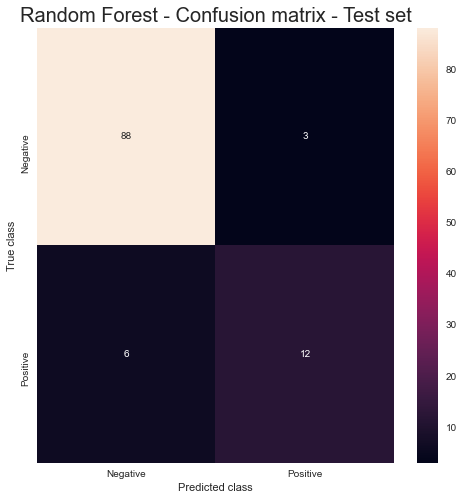

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.906


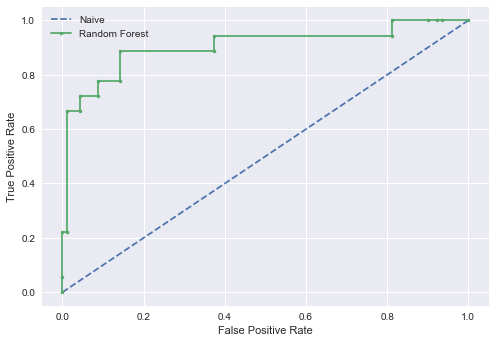

In [10]:
model_utils.evalute_model_performance(best_random_forest, 'Random Forest',X_test_norm,y_test)

### SVM

In [11]:
svm_params = {
    'C' : [0.1,0.5,1,10,20,50,100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[2,3,4],
    'coef0':[0,1,5,7,10],
    'class_weight':[None,'balanced']
}

best_svm,best_svm_params,best_svm_score = model_utils.model_fit_with_grid_search_cv(
    SVC(probability = True),
    svm_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    8.0s
--- Ellapsed time: 16.736992120742798 seconds ---
Best params:  {'C': 1, 'class_weight': 'balanced', 'coef0': 7, 'degree': 4, 'kernel': 'poly'}
Best score (make_scorer(fbeta_score, beta=2)) 0.8130645685792744
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:   16.6s finished



Performance Report: 
Accuracy: 0.881
Recall: 0.706
Precision: 0.813
F1: 0.741
F2: 0.717



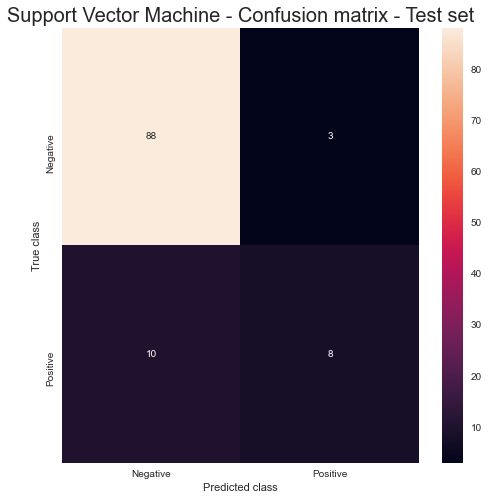

No Skill: ROC AUC=0.500
Support Vector Machine : ROC AUC=0.869


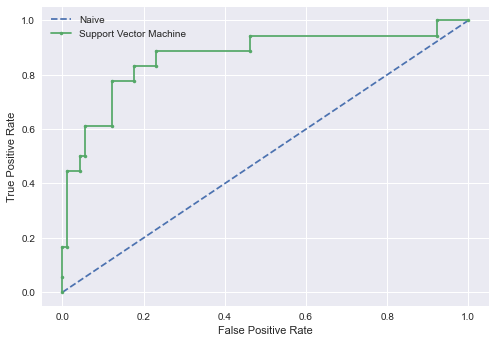

In [12]:
model_utils.evalute_model_performance(best_svm, 'Support Vector Machine',X_test_norm,y_test)


### Visualizing weights of the Logistic Regression

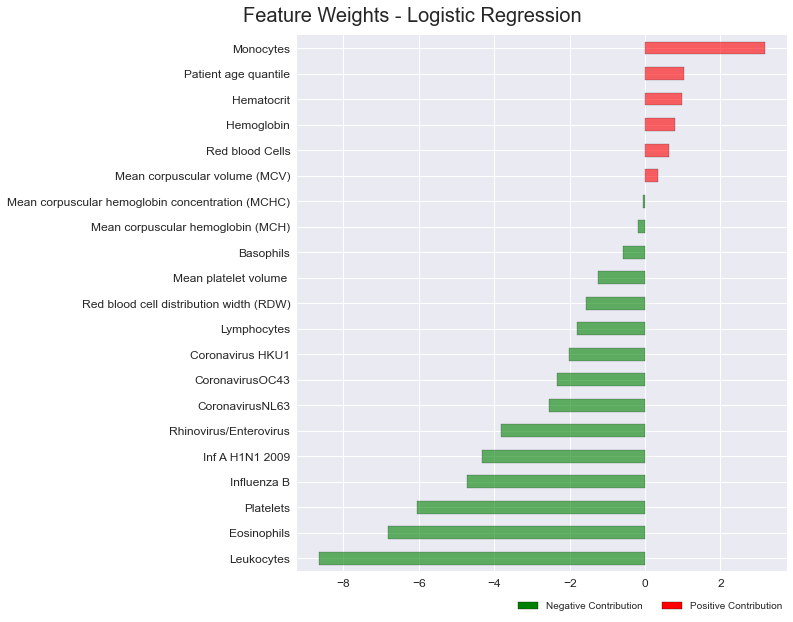

In [13]:
feature_importance_utils.show_feature_weights(columns_x,best_lr.coef_.ravel(),'Logistic Regression', color = ('r','g'), absolute_values = False)

## Visualizing Feature Weights from SVM and RandomForest with SHAP values

### Random Forest

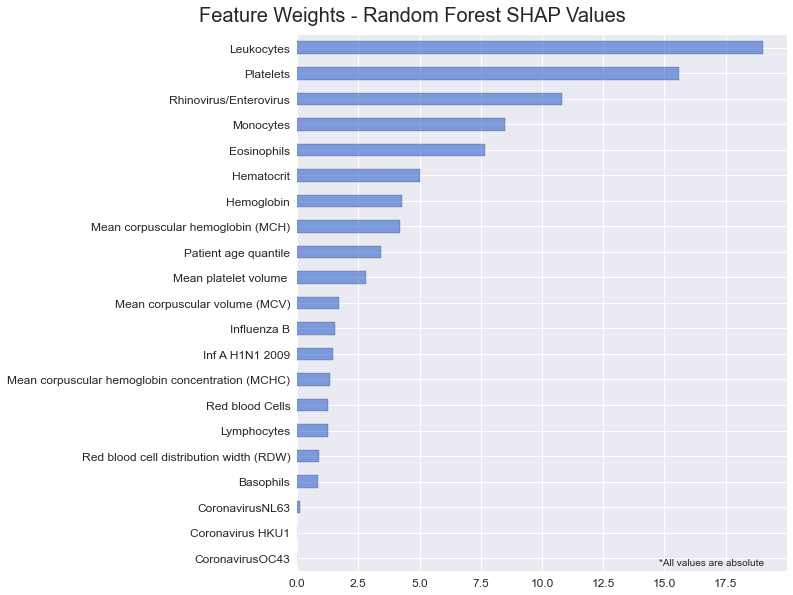

In [14]:
explainer_rf = shap.TreeExplainer(best_random_forest,X_train_norm)
shap_values_rf = explainer_rf.shap_values(X_train_norm,check_additivity=False)[0]
coef_rf = np.abs(shap_values_rf).sum(axis=0).ravel()

feature_importance_utils.show_feature_weights(columns_x,coef_rf,'Random Forest SHAP Values', absolute_values = True)

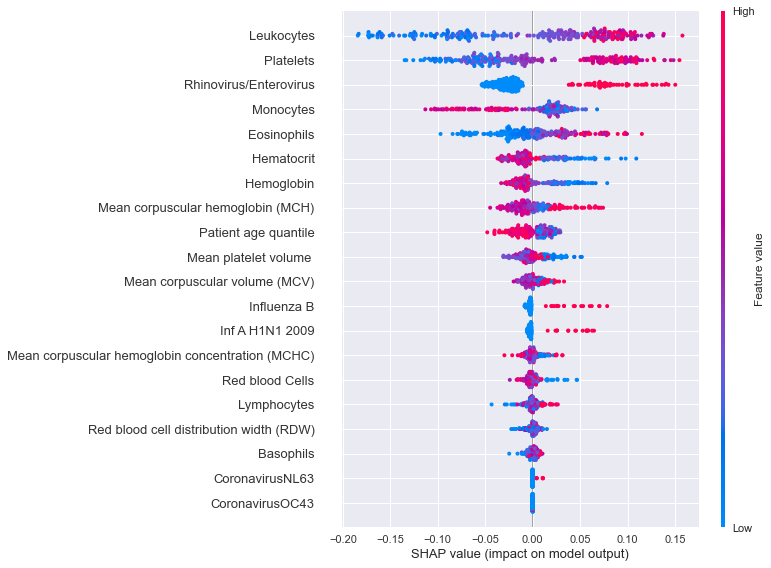

In [15]:
shap.summary_plot(shap_values_rf, X_train_norm)

In [16]:
explainer_svm = shap.SamplingExplainer(best_svm.predict_proba,X_train_norm)

In [17]:
shap_values_svm = explainer_svm.shap_values(X_train_norm)[0]

100%|██████████| 253/253 [00:54<00:00,  4.67it/s]


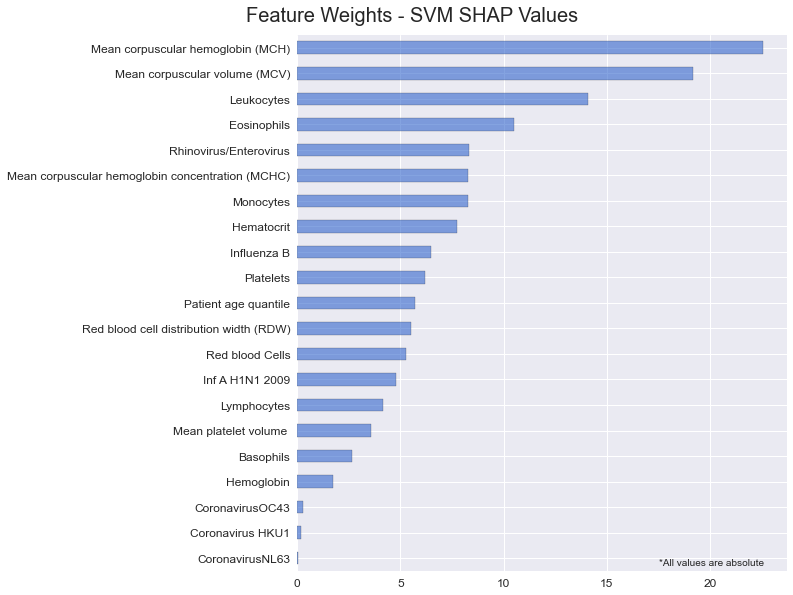

In [18]:
coef_svm = np.abs(shap_values_svm).sum(axis=0).ravel()

feature_importance_utils.show_feature_weights(columns_x,coef_svm,'SVM SHAP Values', absolute_values = True)

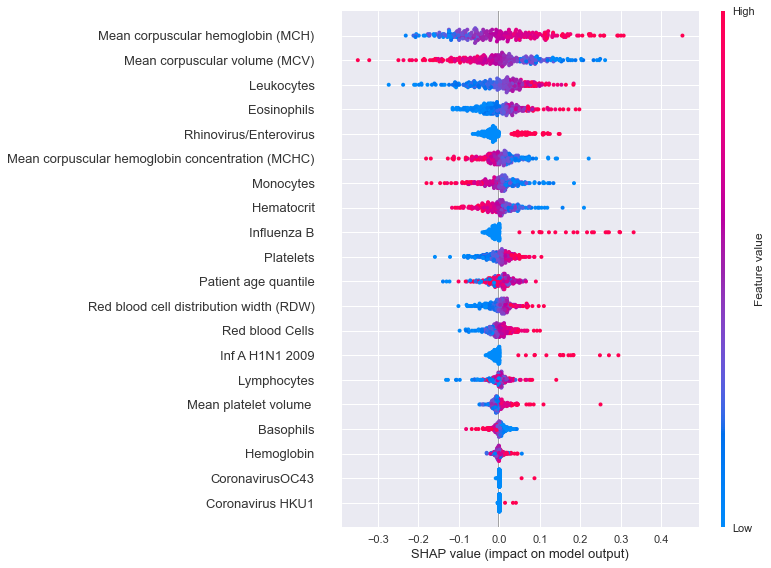

In [19]:
shap.summary_plot(shap_values_svm, X_train_norm)


### Let us try to tune again the Logistic Regression with only 6 features (selected during the RFE)

In [20]:
lr_features = ['Leukocytes','Eosinophils','Platelets','Influenza B','Inf A H1N1 2009','Rhinovirus/Enterovirus']

best_lr_2,best_lr_2_params,best_lr_2_score = model_utils.model_fit_with_grid_search_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm[lr_features].values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
--- Ellapsed time: 0.8169991970062256 seconds ---
Best params:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best score (make_scorer(fbeta_score, beta=2)) 0.7670651476251604
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.7s finished



Performance Report: 
Accuracy: 0.826
Recall: 0.829
Precision: 0.723
F1: 0.750
F2: 0.788



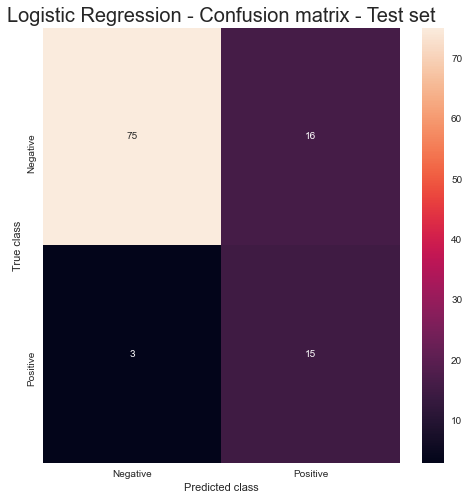

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.879


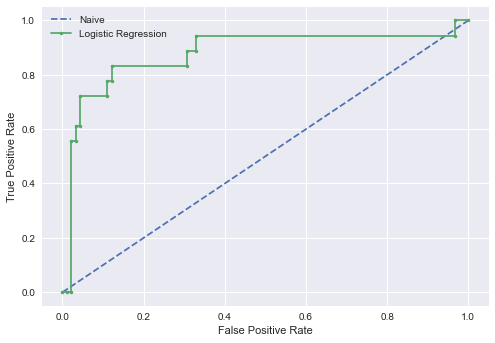

In [21]:
model_utils.evalute_model_performance(best_lr_2, 'Logistic Regression',X_test_norm[lr_features],y_test)

## Conclusion

Best result was with the Random Forest with all 28 variables (F2 = 0.86).

Second best was with the Logistic Regression with 21 variables (F2 = 0.83).

Some interestinng results were achieved with Linear Regression and RFE: 6 variables got F2 = 0.79